### Preliminary Actions: Read the data set from csv file. Create dummy variables for the nine levels of rural_urbal_continuum_codes (RUCC) and the four geographical regions. Create the predictors data frame and the target variable series.

In [193]:
# Set the backend of matplotlib to inline
%matplotlib inline

# Improt necessary libraries
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
import seaborn as sns

# Set style and context
sns.set_style('whitegrid')
sns.set_context('talk')

# Load the data set
df = pd.read_csv('wrangled_data.csv')
# Remove the .0 after RUCC numbers and transform it to string
df.RUCC=df.RUCC.astype('int').astype('str')

# define the predictors dataframe and the target variable series
X = df.drop(['state','county','poverty'],axis=1)
y = df['poverty']

# Create dummy variables for region and RUCC
X=pd.get_dummies(X)

# drop one column of dummy variable from each categorical variable to avoid collinearity
# The correlations between poverty and majority of rural urban continuum codes i.e. all except RUCC 1 and 6, 
# are close to each other . Therefore, any of these seven RUCC could be picked as the base to simplify the interpretation. 
# I pick RUCC 9 and remove it
# The correlations between poverty and the four geographical regions are different from each other. Therefore, any of them 
# could be picked as the base. I pick Midwest and remove it
# Also, the sum of the four education levels is 100 and one of them must be removed to avoid collinearity. 
# Since poverty is positively correlated with lower education (this was shown in Story Telling), I removed the highest education
# level which is bachelors/higher

X.drop(['region_Midwest','RUCC_9','bachelors/higher'],axis=1,inplace=True)

#Print the first five rows of X
X.head()

,less_than_high_school,high_school_diploma,college/associate_degree,unemployment,region_Northeast,region_South,region_West,RUCC_1,RUCC_2,RUCC_3,RUCC_4,RUCC_5,RUCC_6,RUCC_7,RUCC_8
0,12.417,34.331,28.660,5.3,0,1,0,0,1,0,0,0,0,0,0
1,9.972,28.692,31.788,5.4,0,1,0,0,0,1,0,0,0,0,0
2,26.236,34.927,25.969,8.6,0,1,0,0,0,0,0,0,1,0,0
3,19.302,41.816,26.883,6.6,0,1,0,1,0,0,0,0,0,0,0
4,19.969,32.942,34.039,5.5,0,1,0,1,0,0,0,0,0,0,0


### Step 1: There are 15 predictors and more than 3000 samples. Therefore, I will build a model based on all predictors, run a cross-validation, and average them to find an estimate for the test set score

In [194]:
# Build the classifier and calculate the average score
clf = LinearRegression()
scores = cross_val_score(clf,X,y,cv=5)
print('The average of 5-fold cross-validation for the linear model is %.3f'%np.mean(scores))

The average of 5-fold cross-validation for the linear model is 0.525


### Conclusion 
#### The R-square of the test set for the linear model is not high enough. 

### Step 2: I will find and investigate the outliers and exmaine how removing them will impact the R-sqaure. I consider a data point an oulier if the the absolute value of the external studentized residual corresponding to that point is more than 3. I pick 3 because more than 99% of the observations for a normal distribution fall within 3 standard deviation of the mean

#### Step 2-1: Find the outliers and analyze them

In [195]:
# Fit the model
model = sm.OLS(y,X).fit()

# Define the influence array and create a panda Series with the external studentized residuals
infl = model.get_influence()
p = pd.Series(infl.resid_studentized_external)

# Extract the indices of the series for which the absolute value of external studentized residual is more than 3
indices = p[np.abs(p)>3].index
df_outliers = df.iloc[indices]

print('Total number of outliers is ',len(indices), ' which is ',np.round(100*len(indices)/len(df),2), \
      ' percent of the total number of counties\n')

# Print the top 5 states with outlier counties, number of those counties,
#and the print this number as the percentage of total num ber of counties in that state
for state,value in df_outliers.state.value_counts().head().iteritems():
    a=(df['state'] == state).sum ()
    print('State ',state,' shows up ',value,' times in outliers. This number is ',np.round(value/a*100,2),\
        ' percent of the total number of counties in ', state)

Total number of outliers is  46  which is  1.46  percent of the total number of counties

State  SD  shows up  9  times in outliers. This number is  13.64  percent of the total number of counties in  SD
State  LA  shows up  5  times in outliers. This number is  7.81  percent of the total number of counties in  LA
State  TX  shows up  4  times in outliers. This number is  1.57  percent of the total number of counties in  TX
State  MS  shows up  3  times in outliers. This number is  3.66  percent of the total number of counties in  MS
State  VA  shows up  3  times in outliers. This number is  2.26  percent of the total number of counties in  VA


#### Step 2-2: Compute the R-square after removing the outliers

In [196]:
# Build the predictors dataframe and target variable panda series
X_reduced=X.iloc[p[np.abs(p)<=3].index]
y_reduced=y.iloc[p[np.abs(p)<=3].index]

# Build the classifier and calculate the average score
clf = LinearRegression()
scores = cross_val_score(clf,X_reduced,y_reduced,cv=5)
print('The average of 5-fold cross-validation for the linear model after removing the outliers is %.3f'%np.mean(scores))

The average of 5-fold cross-validation for the linear model after removing the outliers is 0.603


### Conclusion
#### By removing the outliers (observations with the absolute value of the external studentized residual more than 3), R-sqaured jumped from 0.52 to 0.60. The outliers formed less than 1.5% of the entire dataset, and there was only one state for which more than 10% of the data was removed. Therefore, removing the outliers did not result in loosing significant amount of data

### Step 3: Examine residual vs fitted value plot, quantile plot, and influence plot before and after removing the outliers

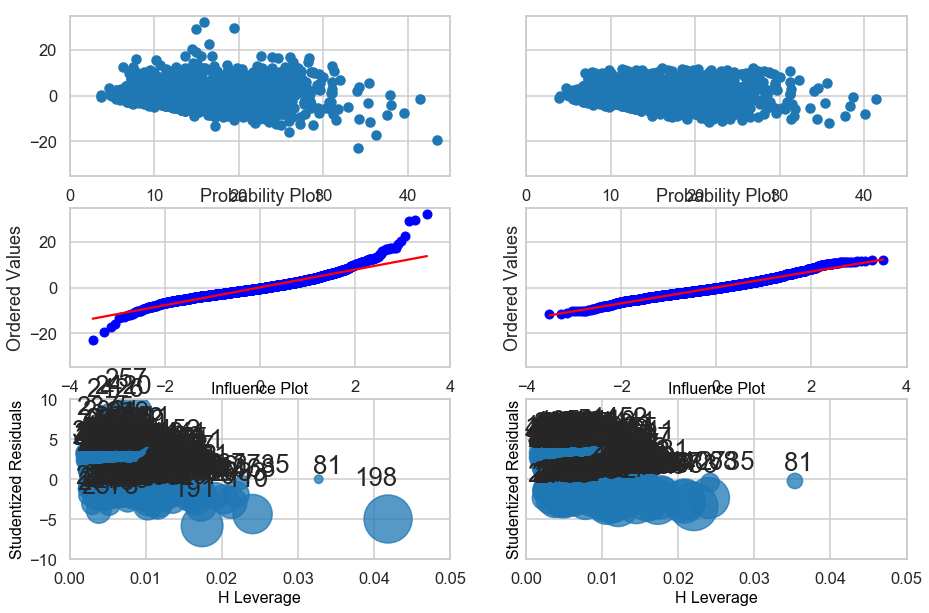

In [205]:
# fit the model on the entire data
model = sm.OLS(y,X).fit()

# fit the model on the data without outliers (reduced data)
model_reduced = sm.OLS(y_reduced,X_reduced).fit()

# Create subplots
figure,ax = plt.subplots(3,2,figsize=(15,10),sharex='row',sharey='row')

# Plot residuals vs. fitted values
ax[0,0].scatter(model.fittedvalues,model.resid)
#plt.xlabel('fitted values');plt.ylabel('residuals');
#ax[0,0].title('Entire data set')
ax[0,0].axis([0,45,-35,35])
ax[0,1].scatter(model_reduced.fittedvalues,model_reduced.resid)
#ax[0,1].title('Data set without outliers')
# Plot quantile plot
#plt.figure(figsize=(10,6))
stats.probplot(model.resid,plot=ax[1,0])
plt.ylabel('')
#plt.title('Quantile plot - entire data set')
ax[1,0].axis([-4,4,-35,35])
#plt.show()
stats.probplot(model_reduced.resid,plot=ax[1,1])
# Plot influence plot
#fig, ax = plt.subplots(figsize=(12,8))
sm.graphics.influence_plot(model,ax=ax[2,0],criterion='cooks')
#plt.title('Influence plot - entire data set')
ax[2,0].axis([0,0.05,-10,10])
sm.graphics.influence_plot(model_reduced,ax=ax[2,1],criterion='cooks')
plt.show()

#### Step 2-4: Examine residual vs fitted value plot, quantile plot, and influence plot after removing the outliers

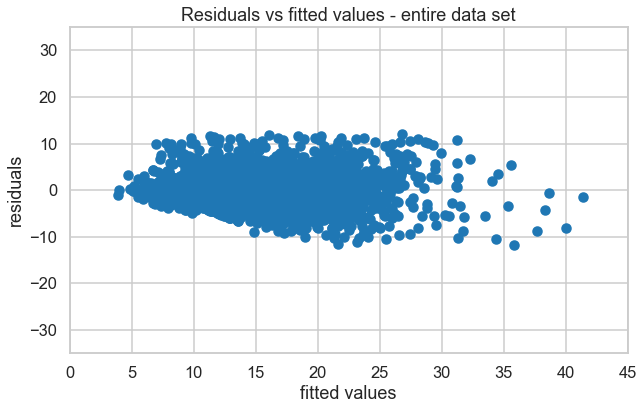

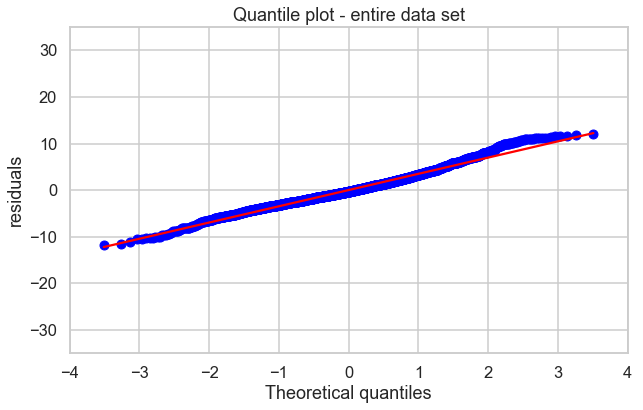

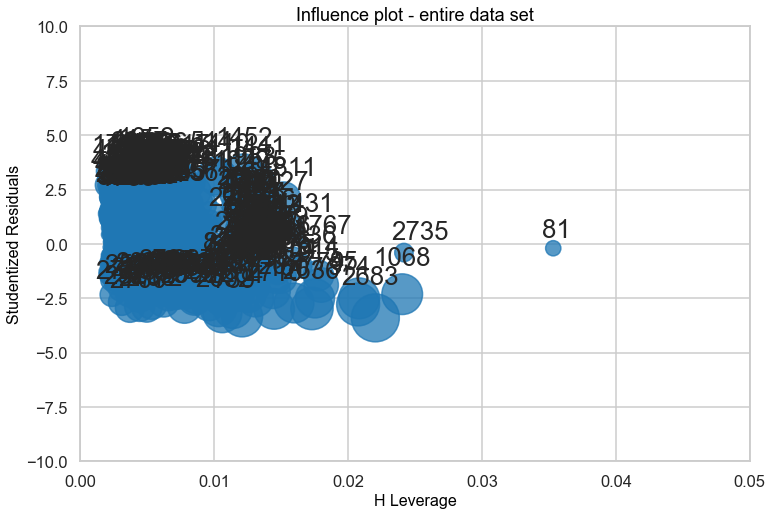

In [181]:
# fit the model
model = sm.OLS(y,X).fit()

# Plot residuals vs. fitted values
plt.figure(figsize=(10,6))
plt.scatter(model.fittedvalues,model.resid)
plt.xlabel('fitted values');plt.ylabel('residuals');
plt.title('Residuals vs fitted values - entire data set')
plt.axis([0,45,-35,35])
plt.show()

# Plot quantile plot
plt.figure(figsize=(10,6))
stats.probplot(model.resid, plot=plt)
plt.ylabel('residuals')
plt.title('Quantile plot - entire data set')
plt.axis([-4,4,-35,35])
plt.show()

# Plot influence plot
fig, ax = plt.subplots(figsize=(12,8))
sm.graphics.influence_plot(model,ax=ax,criterion='cooks')
plt.title('Influence plot - entire data set')
plt.axis([0,0.05,-10,10])
plt.show()

### Step 2: Before trying to investigate the linear model, I will add both nonlinearity and interaction between predictors to the model and examine if R-square of the test set improves.

In [121]:
# Import necessary libraries
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Create linear regression classifier and polynomial features, and use pipeline
linear = LinearRegression()
poly = PolynomialFeatures(degree = 2, interaction_only = False)
pipeline = make_pipeline(poly, linear)

# Run cross-validation and print the results
scores = cross_val_score(pipeline,X,y,cv=5)
print('The average of 5-fold cross-validation of the new model is %.3f'%np.mean(scores))

The average of 5-fold cross-validation of the new model is 0.564


### Conclusion
#### The R-square of the test set for the model with second degree interactions and nonlinearity has not improved significantly compare to the linear model

### Step 3: In Story Telling section, a new education variable was introduced to be used instead of the four education levels. This variable was the sum of college/associate_degree and bachelors/higher. A new model for the poverty is developed based on this new education variable, unemployment and the dummy variables. 

In [51]:
# Add the new column to the dataframe
df_copy = df.copy()
df_copy['more_than_high_school']=df['college/associate_degree'] + df['bachelors/higher']
X = df_copy.iloc[:,5:]
y = df_copy['poverty']

# Build the model, run cross-validation, and average the results
clf = LinearRegression()
scores = cross_val_score(clf,X,y,cv=5)
print('The average of 5-fold cross-validation is %.3f'%np.mean(scores))

The average of 5-fold cross-validation is 0.478


### Conclusion
#### The R-square of the test set goes down.

### Step 4: Another new variable for education is defined. It is called education_index and is a linear combination of less_than_high_school, high_school_diploma, and college/associate_degree. Since the sum of the four education levels is constant (100), one of them (in this case bachelors/higher) is not included in the linear combination. education_index is ranged from 0 to 100, and its higher value means lower education; 0 means the entire county population has bachelors or higher and 100 means the no one in the entire county population has even high school diploma. A new model for the poverty is developed based on this new education variable, unemployment and the dummy variables. 

In [133]:
# Add the new column to the dataframe
X_copy = X.copy()
X_copy['education_index']=(3*X_copy.loc[:,'less_than_high_school']+2*X_copy.loc[:,'high_school_diploma']\
+X_copy.loc[:,'college/associate_degree'])/3
X_copy = X_copy.drop(['less_than_high_school','high_school_diploma','college/associate_degree'],axis=1)
y = df['poverty']

# Build the model, run cross-validation, and average the results
clf2 = LinearRegression()
scores = cross_val_score(clf2,X_copy,y,cv=5)
print('The average of 5-fold cross-validation is %.3f'%np.mean(scores))

The average of 5-fold cross-validation is 0.491


In [135]:
X_copy.head()

,unemployment,region_Northeast,region_South,region_West,RUCC_1,RUCC_2,RUCC_3,RUCC_4,RUCC_5,RUCC_6,RUCC_7,RUCC_8,education_index
0,5.3,0,1,0,0,1,0,0,0,0,0,0,44.857667
1,5.4,0,1,0,0,0,1,0,0,0,0,0,39.696000
2,8.6,0,1,0,0,0,0,0,0,1,0,0,58.177000
3,6.6,0,1,0,1,0,0,0,0,0,0,0,56.140333
4,5.5,0,1,0,1,0,0,0,0,0,0,0,53.276667


In [132]:
# Define a new data frame and add the education_index column
df_extended = df.copy()
df_extended['education_index']=np.round((3*df_extended.iloc[:,3]+2*df_extended.iloc[:,4]+df_extended.iloc[:,5])/3,2)

# Define the new predictor dataframe which contains only one education related column (education_index) instead of three
X_extended = df_extended.drop(['poverty_percentage','less_than_high_school_percentage_adults_only',\
                              'high_school_diploma_percentage_adults_only','some_college_or_associate_degree_percentage'],axis=1)

# Build the classifier and calculate the average score
clf = LinearRegression()
scores = cross_val_score(clf,X_extended,y,cv=5)
print('The average of 5-fold cross-validation for the new model with only one education-related predictor is %f'%np.mean(scores))

The average of 5-fold cross-validation for the new model with only one education-related predictor is 1.000000


<div class="span5 alert alert-info">
<b> Conclusion:</b> The R-square is improved significantly.
<br/>
<br/>
<b>Step 3:</b> The linear regression model is fitted on the entire data set and linearity, constant standard deviation, and normal distribution of errors are examined via residuals v.s. fitted values plot and quantile plot
</div>

<div class="span5 alert alert-info">
<b>Conclusion:</b>The residuals do not bounce normally around the 0 residual line. Therefore, the model is not linear. Also, the quantile plot shows that the residuals do not have normal distribution. 
<br/>
<br/>
<b>Step 4:</b> It was shown in the Data Story Telling that education_index and unemployment_rate are highly correlated. Since higher education typically results in better employment opportunities and it is not the other way around, unemployment_rate is removed from the predictors, model is fit again, cross-validation is run, and the test set score is estimated by averaging the results. Then, the linear regression model is fitted on the entire data set and residuals v.s. fitted values and quantile plots are examined again
</div>

The average of 5-fold cross-validation when the unemployment rate is removed from predictors is 0.979


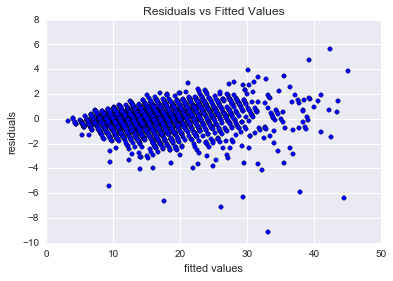

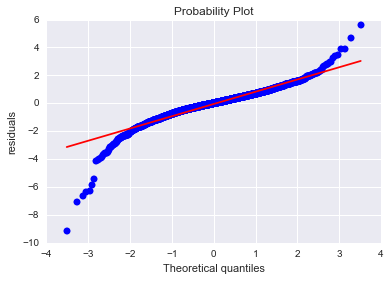

In [193]:
# Create new predictor dataframe
X_reduced = X_extended.drop('unemployment_rate', axis=1)

# Build the model and run cross validation to evaluate the new model
clf = LinearRegression()
scores = cross_val_score(clf,X_reduced,y,cv=5)
print('The average of 5-fold cross-validation when the unemployment rate is removed from predictors is %.3f'%np.mean(scores))

# fit the model to the entire data set
model = sm.OLS(y,X_reduced).fit()

# plot residual vs fitted values and quantile plots
plt.scatter(model.fittedvalues,model.resid)
plt.xlabel('fitted values');plt.ylabel('residuals');plt.title('Residuals vs Fitted Values')
plt.show()

# plot quantile plot
stats.probplot(model.resid, plot=plt)
plt.ylabel('residuals')
plt.show()

<div class="span5 alert alert-info">
<b>Conclusion:</b> The average of cross-validation scores is a little less than before (0.979 compared to 1) but a significant improvement is observed in the plots; the residuals are randomly bouncing around 0-residual line i.e. the model is linear, the residuals roughly form a horizontal band around the 0 line, i.e the variances of the error terms are equal, and the residuals are close to theoretical quantiles, i.e. they are close to normal distribution 
<br/>
<br/>
<b>Step 5:</b> The coefficients of the predictors are analyzied to find the statistically significant ones
</div>

In [176]:
# print the summary of the model
model = sm.OLS(y,X_reduced).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     poverty_percentage   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 1.205e+05
Date:                Tue, 04 Dec 2018   Prob (F-statistic):               0.00
Time:                        08:46:32   Log-Likelihood:                -4157.5
No. Observations:                3121   AIC:                             8333.
Df Residuals:                    3112   BIC:                             8387.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
rural_urban_cont

<div class="span5 alert alert-info">
<b>Conclusion:</b> The p-values of all the coefficents are small enough to conclude they are statistically significant. 
<br/>
<br/>
<b>Step 6:</b> In the Story Telling section, it was shown that the correlation coefficient between RUCC and poverty is much smaller than the correlation coefficient between education index and poverty (0.24 vs. 0.62). Therefore, I am fitting a model based on only education index to determine how the model accuracy will be affected by removing RUCC dummy variables. I will also find the new coefficients
</div>

In [202]:
# create new X and reshape it since it has only one column
X_education = X_reduced['education_index'].reshape(-1,1)

# build the classifier, run cross validation and average the results
clf = LinearRegression()
scores = cross_val_score(clf,X_education,y,cv=5)
print('The average of 5-fold cross validation for the model with the education index as the only predictor is %.3f'%np.mean(scores))

# fit the model on the entire data set and print the summary of results
model = sm.OLS(y,X_education).fit()
print(model.summary())

The average of 5-fold cross validation for the model with the education index as the only predictor is 0.979
                            OLS Regression Results                            
Dep. Variable:     poverty_percentage   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 9.394e+05
Date:                Tue, 04 Dec 2018   Prob (F-statistic):               0.00
Time:                        17:24:24   Log-Likelihood:                -4385.0
No. Observations:                3121   AIC:                             8772.
Df Residuals:                    3120   BIC:                             8778.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------

<div class="span5 alert alert-info">
<b>Conclusion:</b> The average of scores is the same as the model including RUCC dummy variables. Therefore, I pick the model with only education index as the predictor since its interpretation is simpler
<br/>
<br/>
<b>Step 7:</b> Linearity, constant standard deviation, and normal distribution of errors for the new model are examined via residuals v.s. fitted values and quantile plots
</div>

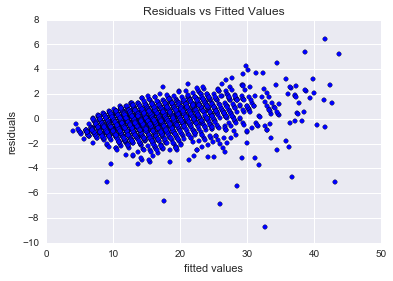

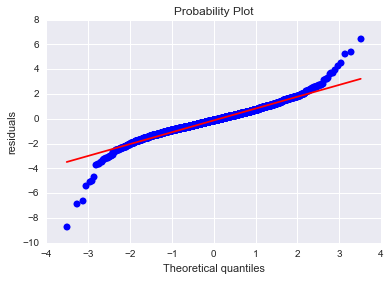

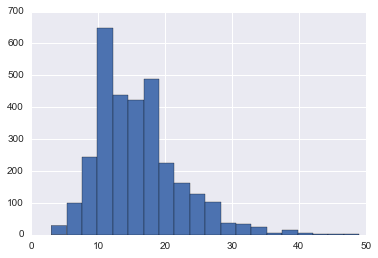

In [203]:
# plot residual vs fitted values and quantile plots
plt.scatter(model.fittedvalues,model.resid)
plt.xlabel('fitted values');plt.ylabel('residuals');plt.title('Residuals vs Fitted Values')
plt.show()

# plot quantile plot
stats.probplot(model.resid, plot=plt)
plt.ylabel('residuals')
plt.show()

plt.hist(y,bins=20)
plt.show()

<div class="span5 alert alert-info">
<b>Conclusion:</b> The residuals are randomly bouncing around 0-residual line i.e. the model is linear, the residuals roughly form a horizontal band around the 0 line, i.e the variances of the error terms are equal, and the residuals are close to theoretical quantiles, i.e. they are close to normal distribution 

<div class="span5 alert alert-info">
<b>Summary of Results</b>
<br/>
<br/>
<b>1) </b>The poverty percentage across U.S. counties can be predicted based on only the education index. Unemployment rate and RUCC do not add more value to the model. 
<br/>
<br/>
<b>2) </b>The fitting model between the education index and the poverty percentage is a linear model with no intercept and the coefficient of 0.825 for which the 95% confidence interval is (0.823,0.825). It means, for every one unit increases in the education index, the average of poverty percentage increase by 0.825 percent
<br/>
<br/>
<b>3) </b>This model satisfies linearity, equal variance of errors, and normal distribution of errors with good enough estimation